<a href="https://colab.research.google.com/github/Imranzr/Developing_EEG_Based_Auditory_Brain_Computer_Interface_Using_Deep_Learning_-_Machine_Learning_Model/blob/main/fine_Auditory_BCI_Sliding_and_Overlapping_Window_epoching_based_Machine_Learning(ML)_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 41.3 MB/s eta 0:00:00


In [4]:
pip install pyriemann

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.9 MB/s eta 0:00:00


In [5]:
import os
import argparse
import sys
import mne
import math
import time
import json
import numpy as np
from scipy.signal import butter, filtfilt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, matthews_corrcoef

start = time.time()


def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True
        elif shell == 'TerminalInteractiveShell':
            return False
        else:
            return False
    except NameError:
        return False

if is_notebook():
    args = argparse.Namespace(s=None, c=None)
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('-s', default=None)
    parser.add_argument('-c', default=None, type=int)

    args = parser.parse_args(args=[])

print(args.s)
print(args.c)
print(__doc__)

subject = 'sub-B'
if args.s is not None:
    subject = args.s
test_class =1
if args.c is not None:
    test_class = args.c

import numpy as np
fnum = np.array([[1,4],
                 [2,5],
                 [3,6]])

trig_id = [2,8,32]
tasks = ['low', 'low', 'mid', 'mid', 'high', 'high']
reject={'eeg':100e-6,'eog':500e-6}

import os
import json
repository_base = os.path.dirname(os.path.dirname(os.path.abspath('/content/drive/MyDrive/dataverse_files/results/sub-B_classification_scores.json')))

#repository_base = os.path.dirname(os.path.dirname(os.path.abspath('file_path')))
base = os.path.join(repository_base, "eeg")
save_base = os.path.join(repository_base, "results")
if not os.path.exists(save_base):
    os.makedirs(save_base)

Fs = 1000
fc = [1, 40]
resample = None

from scipy.signal import butter, filtfilt
def apply_filter(data, b, a):
    r = filtfilt(b=b, a=a, x=data)
    return r
b,a = butter(N = 2, Wn = np.array(fc)/(Fs/2), btype = 'bandpass', output = 'ba')

t_file = []
nt_file = []
target_file = []
non_target_file = []

for i in range(len(fnum.ravel())):
    fname = os.path.join(base, subject, "eeg", "%s_task-%s_run-%d_eeg.vhdr" % (subject, tasks[i], fnum.ravel()[i]))
    print(fname)
    if np.any(fnum[test_class-1] == fnum.ravel()[i]):
        if isinstance(target_file, list):
            target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            target_file = target_file.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            t_file.append(fnum.ravel()[i])
        else:
            tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            tmp = tmp.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            target_file = mne.concatenate_raws([target_file, tmp])
            t_file.append(fnum.ravel()[i])
    else:
        if isinstance(non_target_file, list):
            non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            non_target_file = non_target_file.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            nt_file.append(fnum.ravel()[i])
        else:
            tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            tmp = tmp.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            non_target_file = mne.concatenate_raws([non_target_file, tmp])
            nt_file.append(fnum.ravel()[i])
if resample is not None:
    target_file.resample(resample)
    non_target_file.resample(resample)

if resample != None:
    target_file.resample(resample)
    non_target_file.resample(resample)

event_id={'target_stimulus_id':-100,'non_target_stimulus_id':-500}
target_eve = mne.events_from_annotations(target_file)
target_eve = mne.merge_events(target_eve[0],[trig_id[test_class-1]],event_id['target_stimulus_id'],replace_events=True)

non_target_eve = mne.events_from_annotations(non_target_file)
non_target_eve = mne.merge_events(non_target_eve[0],[trig_id[test_class-1]],event_id['non_target_stimulus_id'],replace_events=True)

tmin,tmax= -0.02, 1.4
baseline=(0.0,0.01)
target_epochs = mne.Epochs(target_file,events=target_eve, event_id=event_id['target_stimulus_id'], tmin=tmin,tmax=tmax, baseline=baseline, reject=reject,preload = True)

None
None
Automatically created module for IPython interactive environment
/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-1_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-1_eeg.vhdr...
Setting channel info structure...


<ipython-input-5-fdbca35346cd>:91: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-5-fdbca35346cd>:91: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


Reading 0 ... 317919  =      0.000 ...   317.919 secs...
/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-4_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-4_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 312879  =      0.000 ...   312.879 secs...


<ipython-input-5-fdbca35346cd>:95: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-5-fdbca35346cd>:95: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-2_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-2_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 314879  =      0.000 ...   314.879 secs...


<ipython-input-5-fdbca35346cd>:101: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-5-fdbca35346cd>:101: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-5_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-5_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 315879  =      0.000 ...   315.879 secs...


<ipython-input-5-fdbca35346cd>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-5-fdbca35346cd>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-3_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-3_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 319199  =      0.000 ...   319.199 secs...


<ipython-input-5-fdbca35346cd>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-5-fdbca35346cd>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-6_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-6_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 321519  =      0.000 ...   321.519 secs...


<ipython-input-5-fdbca35346cd>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-5-fdbca35346cd>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S144']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S144']
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 119 events and 1421 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epo

# Sliding and Overlapping Window Epoching

In [6]:

import numpy as np
def find_max_peak_window(data, Fs, window_size_ms=500, overlap_size_ms=100, epoch_index=0):
    """
    Function to find the window with the maximum peak value within a specific epoch and return its start and end indices.
    """
    window_size_samples = int(window_size_ms * Fs / 1000)
    overlap_size_samples = int(overlap_size_ms * Fs / 1000)
    epoch_data = data[epoch_index]
    n_channels, n_times = epoch_data.shape
    max_peak_value = -np.inf
    max_peak_start_index = None
    max_peak_end_index = None
    start = 0
    while start + window_size_samples <= n_times:
        window_data = epoch_data[:, start:start + window_size_samples]
        current_peak_value = np.max(window_data)
        if current_peak_value > max_peak_value:
            max_peak_value = current_peak_value
            max_peak_start_index = start
            max_peak_end_index = start + window_size_samples - 1
        start += (window_size_samples - overlap_size_samples)
    print(f"Epoch {epoch_index + 1} - Max Peak Value: {max_peak_value}")
    print(f"Epoch {epoch_index + 1} - Window Start Index: {max_peak_start_index}, End Index: {max_peak_end_index}")
    return max_peak_start_index, max_peak_end_index

def analyze_all_epochs_max_peaks(data, Fs, window_size_ms=500, overlap_size_ms=100):
    """
    Function to find and print the maximum peak values and corresponding window indices across all epochs.
    """
    n_epochs = data.shape[0]
    peak_window_indices = []
    for epoch_index in range(n_epochs):
        print(f"\nAnalyzing Epoch {epoch_index + 1}")
        start_index, end_index = find_max_peak_window(data, Fs, window_size_ms, overlap_size_ms, epoch_index)
        peak_window_indices.append((start_index, end_index))
    return peak_window_indices

def re_epoch_data(data, peak_window_indices):
    """
    Function to re-epoch the data based on the peak window indices.
    """
    re_epoched_data = []
    for epoch_index, (start, end) in enumerate(peak_window_indices):
        re_epoched_epoch_data = data[epoch_index][:, start:end + 1]
        re_epoched_data.append(re_epoched_epoch_data)
    re_epoched_data = np.array(re_epoched_data)
    print("\nRe-epoching complete.")
    print("Re-epoched data shape:", re_epoched_data.shape)
    return re_epoched_data

Fs = 1000
data = target_epochs.get_data()
peak_window_indices = analyze_all_epochs_max_peaks(data, Fs, window_size_ms=500, overlap_size_ms=100)
re_epoched_data = re_epoch_data(data, peak_window_indices)

from mne import EpochsArray
from mne import create_info
n_channels = re_epoched_data.shape[1]
info = create_info(ch_names=[f'chan{i}' for i in range(n_channels)], sfreq=Fs, ch_types='eeg')
re_epoched_epochs = EpochsArray(re_epoched_data, info)
print("Re-epoched data converted to MNE Epochs:", re_epoched_epochs)



from mne import EpochsArray, create_info
n_channels = re_epoched_data.shape[1]
info = create_info(ch_names=[f'chan{i}' for i in range(n_channels)], sfreq=Fs, ch_types='eeg')
re_epoched_epochs = EpochsArray(re_epoched_data, info)
baseline=(0.0,0.01)
re_epoched_epochs.apply_baseline(baseline)
re_epoched_epochs.filter(l_freq=0.50, h_freq=100.00)
print("Re-epoched data converted to MNE Epochs and processed with baseline correction and filtering.")

tmin,tmax= -0.0, 0.499
baseline=(0.0,0.01)
non_target_epochs = mne.Epochs(non_target_file, events=non_target_eve, event_id=event_id['non_target_stimulus_id'], tmin=tmin,tmax=tmax, baseline=baseline, reject=reject,preload = True)


import mne
tmin, tmax = -0.0, 0.499
baseline=(0.0,0.01)
non_target_epochs = mne.Epochs(
    non_target_file,
    events=non_target_eve,
    event_id=event_id['non_target_stimulus_id'],
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    reject=reject,
    preload=True
)

new_channel_names = [f'chan{i}' for i in range(len(non_target_epochs.ch_names))]
rename_dict = dict(zip(non_target_epochs.ch_names, new_channel_names))
non_target_epochs.rename_channels(rename_dict)
print("Updated channel names:", non_target_epochs.ch_names)




Analyzing Epoch 1
Epoch 1 - Max Peak Value: 5.3609090909090905e-05
Epoch 1 - Window Start Index: 800, End Index: 1299

Analyzing Epoch 2
Epoch 2 - Max Peak Value: 2.9702295397418008e-05
Epoch 2 - Window Start Index: 0, End Index: 499

Analyzing Epoch 3
Epoch 3 - Max Peak Value: 1.9700354081974367e-05
Epoch 3 - Window Start Index: 800, End Index: 1299

Analyzing Epoch 4
Epoch 4 - Max Peak Value: 1.8520261664344037e-05
Epoch 4 - Window Start Index: 0, End Index: 499

Analyzing Epoch 5
Epoch 5 - Max Peak Value: 2.7344734807680046e-05
Epoch 5 - Window Start Index: 0, End Index: 499

Analyzing Epoch 6
Epoch 6 - Max Peak Value: 1.838181818181818e-05
Epoch 6 - Window Start Index: 400, End Index: 899

Analyzing Epoch 7
Epoch 7 - Max Peak Value: 1.841774308675113e-05
Epoch 7 - Window Start Index: 400, End Index: 899

Analyzing Epoch 8
Epoch 8 - Max Peak Value: 1.8918203042186065e-05
Epoch 8 - Window Start Index: 400, End Index: 899

Analyzing Epoch 9
Epoch 9 - Max Peak Value: 1.552001359962160

<ipython-input-6-2346cbd8a145>:71: RuntimeWarning: filter_length (6601) is longer than the signal (500), distortion is likely. Reduce filter length or filter a longer signal.
  re_epoched_epochs.filter(l_freq=0.50, h_freq=100.00)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    8.0s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    9.0s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 3041 t

Re-epoched data converted to MNE Epochs and processed with baseline correction and filtering.
Not setting metadata
237 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 237 events and 500 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
  

In [8]:
epochs = mne.concatenate_epochs([re_epoched_epochs, non_target_epochs])
epochs = epochs.copy().pick_types(eeg=True, eog=False)

<ipython-input-8-e84d836bf4c9>:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([re_epoched_epochs, non_target_epochs])


Not setting metadata
246 matching events found
Applying baseline correction (mode: mean)
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


# Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Classification Report:
{'non-target': {'precision': 0.912621359223301, 'recall': 0.9947089947089947, 'f1-score': 0.9518987341772152, 'support': 189.0}, 'target': {'precision': 0.975, 'recall': 0.6842105263157895, 'f1-score': 0.8041237113402062, 'support': 57.0}, 'accuracy': 0.9227642276422764, 'macro avg': {'precision': 0.9438106796116505, 'recall': 0.8394597605123921, 'f1-score': 0.8780112227587107, 'support': 246.0}, 'weighted avg': {'precision': 0.927074946720341, 'recall': 0.9227642276422764, 'f1-score': 0.9176581801052254, 'support': 246.0}}


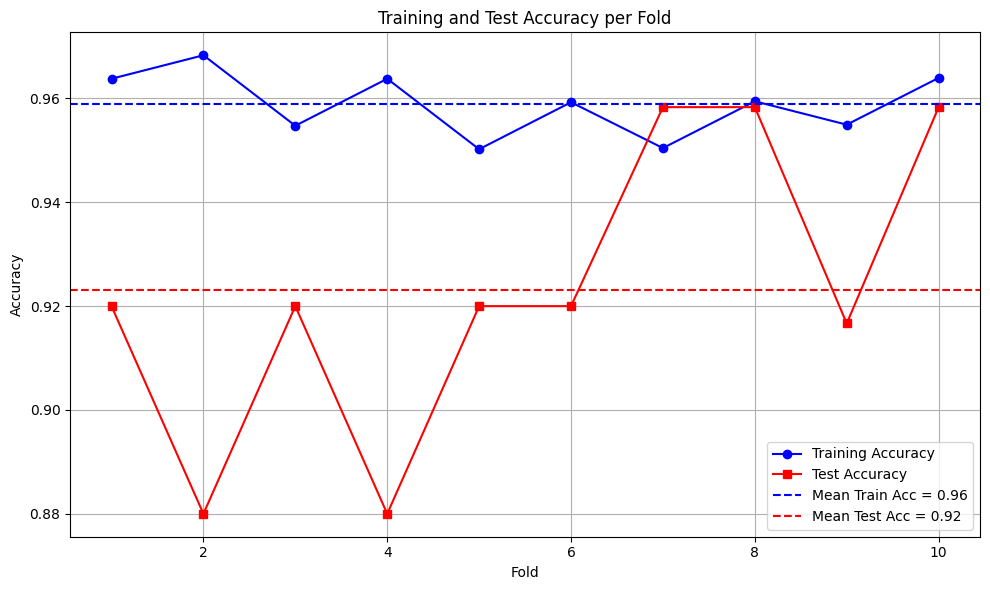

<Figure size 800x600 with 0 Axes>

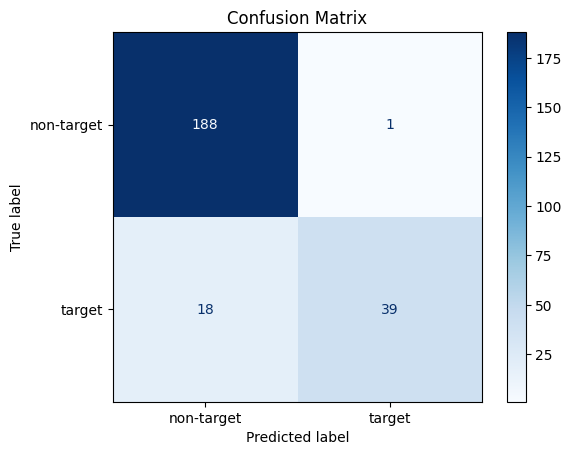

In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import numpy as np

# Define the classifier pipeline without StandardScaler (XdawnCovariances handles 3D data)
clf = Pipeline([
    ('xdawn', XdawnCovariances(1)),  # Increase components to capture more signal
    ('tspace', TangentSpace(metric='riemann')),
    ('logreg', LogisticRegression(penalty='l2', solver='newton-cholesky', C=0.13, multi_class='ovr', max_iter=100))
])


#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

epochs_data = epochs.get_data()  # Shape: (n_samples, n_channels, n_timepoints)
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_accuracies, test_accuracies = [], []

for train_idx, test_idx in cv.split(epochs_data, labels):
    # Extract train and test data
    train_data = epochs_data[train_idx]
    test_data = epochs_data[test_idx]

    # Fit the classifier
    clf.fit(train_data, labels[train_idx])

    # Predict on train and test sets
    train_preds = clf.predict(train_data)
    test_preds = clf.predict(test_data)

    # Calculate train and test accuracies
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Save predictions for final evaluation
    preds[test_idx] = test_preds

# Print classification report
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print("Classification Report:")
print(report)

# Plot Train/Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(np.mean(train_accuracies), linestyle='--', color='blue', label=f"Mean Train Acc = {np.mean(train_accuracies):.2f}")
plt.axhline(np.mean(test_accuracies), linestyle='--', color='red', label=f"Mean Test Acc = {np.mean(test_accuracies):.2f}")
plt.title("Training and Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


Fine Tune logistic regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters found:  {'logisticregression__C': 10, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l1', 'xdawncovariances__nfilter': 16}
Best cross-validation score:  0.976
{'non-target': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 189.0}, 'target': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 57.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 246.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 246.0}}


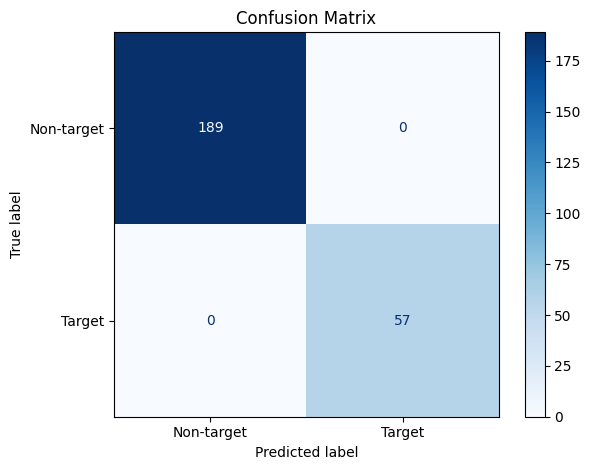

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import numpy as np

# Define the classifier pipeline
clf = make_pipeline(XdawnCovariances(8),
                    TangentSpace(metric='logeuclid'),
                    LogisticRegression(solver='liblinear', multi_class='ovr'))

# Define the parameter grid to tune
param_grid = {
    'logisticregression__penalty': ['l1', 'l2'],  # Regularization penalty
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'logisticregression__max_iter': [100, 200, 300],  # Maximum number of iterations
    'xdawncovariances__nfilter': [4, 8, 16],  # Number of spatial filters in xDAWN
}

# Define the GridSearchCV with 10-fold cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

epochs_data = epochs.get_data()
labels = epochs.events[:, -1]

# Fit the model using GridSearchCV
grid_search.fit(epochs_data, labels)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Use the best model from grid search to make predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
preds = best_model.predict(epochs_data)

# Print classification report
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)

# Plot Train and Test Accuracy (Optional)
# For GridSearchCV, you can track accuracy on each fold during cross-validation

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
conf_matrix = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-target', 'Target'])

disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


#Support Vector Machine (SVM)

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

clf = make_pipeline(XdawnCovariances(8),
                    TangentSpace(metric='logeuclid'),
                    SVC(kernel='linear', C=1, decision_function_shape='ovr'))


epochs_data = epochs.get_data()
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    preds[test_idx] = test_preds
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)





{'non-target': {'precision': 0.958974358974359, 'recall': 0.9894179894179894, 'f1-score': 0.9739583333333334, 'support': 189.0}, 'target': {'precision': 0.9607843137254902, 'recall': 0.8596491228070176, 'f1-score': 0.9074074074074074, 'support': 57.0}, 'accuracy': 0.959349593495935, 'macro avg': {'precision': 0.9598793363499246, 'recall': 0.9245335561125034, 'f1-score': 0.9406828703703705, 'support': 246.0}, 'weighted avg': {'precision': 0.9593937387337673, 'recall': 0.959349593495935, 'f1-score': 0.9585379968383018, 'support': 246.0}}


Plot of Results of SVM

Classification Report:
{'non-target': {'precision': 0.9735449735449735, 'recall': 0.9735449735449735, 'f1-score': 0.9735449735449735, 'support': 189.0}, 'target': {'precision': 0.9122807017543859, 'recall': 0.9122807017543859, 'f1-score': 0.9122807017543859, 'support': 57.0}, 'accuracy': 0.959349593495935, 'macro avg': {'precision': 0.9429128376496797, 'recall': 0.9429128376496797, 'f1-score': 0.9429128376496797, 'support': 246.0}, 'weighted avg': {'precision': 0.959349593495935, 'recall': 0.959349593495935, 'f1-score': 0.959349593495935, 'support': 246.0}}
Overall Train Accuracy: 0.98
Overall Test Accuracy: 0.96


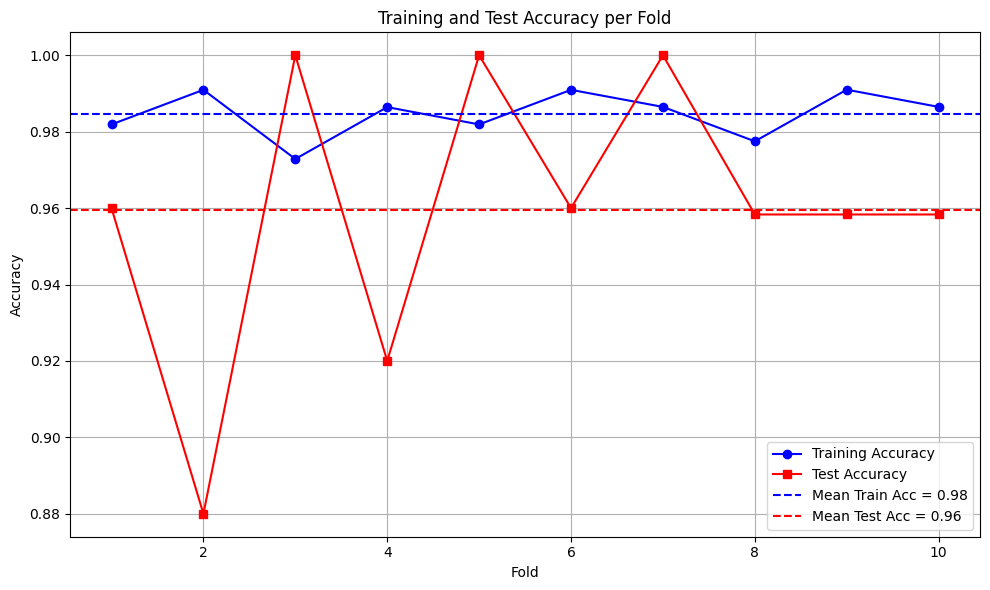

<Figure size 800x600 with 0 Axes>

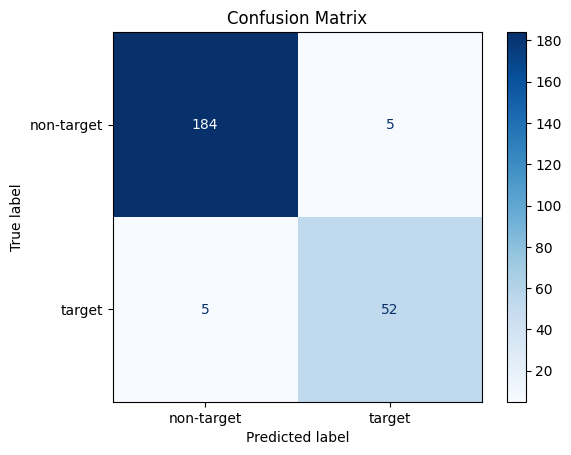

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.svm import SVC

# Initialize the model pipeline
clf = make_pipeline(XdawnCovariances(1),
                    TangentSpace(metric='logeuclid'),
                    SVC(kernel='linear', C=1, decision_function_shape='ovr'))

# Extract data and labels
epochs_data = epochs.get_data()
labels = epochs.events[:, -1]

# Initialize variables
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
preds = np.empty(len(labels))

# Cross-validation loop
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])

    # Calculate accuracy and loss
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    preds[test_idx] = test_preds

# Generate classification report
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print("Classification Report:")
print(report)

# Overall numerical accuracy
print(f"Overall Train Accuracy: {np.mean(train_accuracies):.2f}")
print(f"Overall Test Accuracy: {np.mean(test_accuracies):.2f}")

# Plot training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(np.mean(train_accuracies), linestyle='--', color='blue', label=f"Mean Train Acc = {np.mean(train_accuracies):.2f}")
plt.axhline(np.mean(test_accuracies), linestyle='--', color='red', label=f"Mean Test Acc = {np.mean(test_accuracies):.2f}")
plt.title("Training and Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Random Forest

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import numpy as np




clf = make_pipeline(
    XdawnCovariances(1),
    TangentSpace(metric='riemann'),
    RandomForestClassifier(
        n_estimators=175,
        max_depth=30,
        max_features='sqrt',
        min_samples_split=8,
        class_weight='balanced_subsample',
        min_samples_leaf=30,
        bootstrap=False,  # Corrected: Use boolean True (not a string)
        random_state=42
    )
)



epochs_data = epochs.get_data()
labels = epochs.events[:, -1]

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    preds[test_idx] = test_preds

report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)

{'non-target': {'precision': 0.9890710382513661, 'recall': 0.9576719576719577, 'f1-score': 0.9731182795698925, 'support': 189.0}, 'target': {'precision': 0.873015873015873, 'recall': 0.9649122807017544, 'f1-score': 0.9166666666666666, 'support': 57.0}, 'accuracy': 0.959349593495935, 'macro avg': {'precision': 0.9310434556336196, 'recall': 0.961292119186856, 'f1-score': 0.9448924731182795, 'support': 246.0}, 'weighted avg': {'precision': 0.9621802072821665, 'recall': 0.959349593495935, 'f1-score': 0.9600380277996329, 'support': 246.0}}


fine tuing code Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import numpy as np

# Define the pipeline
clf = make_pipeline(
    XdawnCovariances(1),
    TangentSpace(metric='riemann'),
    RandomForestClassifier(random_state=42)
)

# Set up parameter grid for RandomizedSearchCV
param_dist = {
    'randomforestclassifier__n_estimators': [50, 100, 150, 200],
    'randomforestclassifier__max_depth': [None, 5, 10, 20, 30],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__min_samples_split': [2, 4, 8],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4, 8],
    'randomforestclassifier__class_weight': ['balanced', None],
    'randomforestclassifier__bootstrap': [True, False]
}

# Set up Stratified KFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation and hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=50, cv=cv,
                                   verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(epochs_data, labels)

# Print the best hyperparameters
print(f"Best Hyperparameters: {random_search.best_params_}")

# Get the best estimator (pipeline with the best parameters)
best_clf = random_search.best_estimator_

# Evaluate on the training and test set
train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    best_clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = best_clf.predict(epochs_data[train_idx])
    test_preds = best_clf.predict(epochs_data[test_idx])

    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    preds[test_idx] = test_preds

# Print classification report
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
140 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 660, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/p

Best Hyperparameters: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__class_weight': None, 'randomforestclassifier__bootstrap': False}
{'non-target': {'precision': 0.9893617021276596, 'recall': 0.9841269841269841, 'f1-score': 0.986737400530504, 'support': 189.0}, 'target': {'precision': 0.9482758620689655, 'recall': 0.9649122807017544, 'f1-score': 0.9565217391304348, 'support': 57.0}, 'accuracy': 0.9796747967479674, 'macro avg': {'precision': 0.9688187820983125, 'recall': 0.9745196324143692, 'f1-score': 0.9716295698304693, 'support': 246.0}, 'weighted avg': {'precision': 0.9798418123579622, 'recall': 0.9796747967479674, 'f1-score': 0.9797362106939026, 'support': 246.0}}


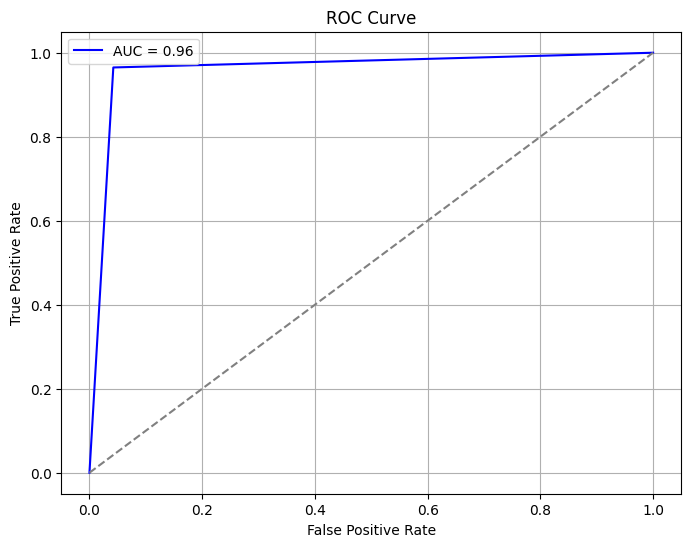

Logarithmic Loss: 1.47


<Figure size 800x600 with 0 Axes>

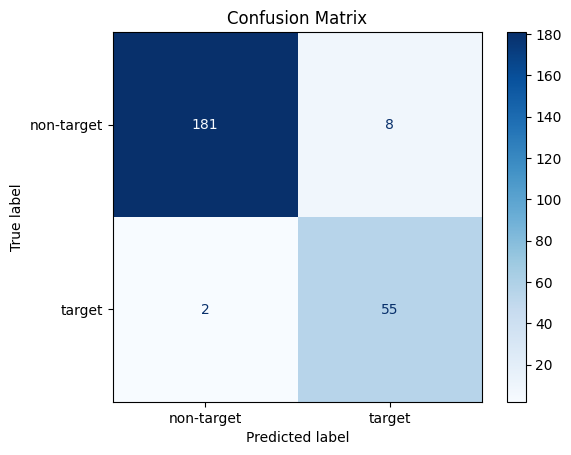

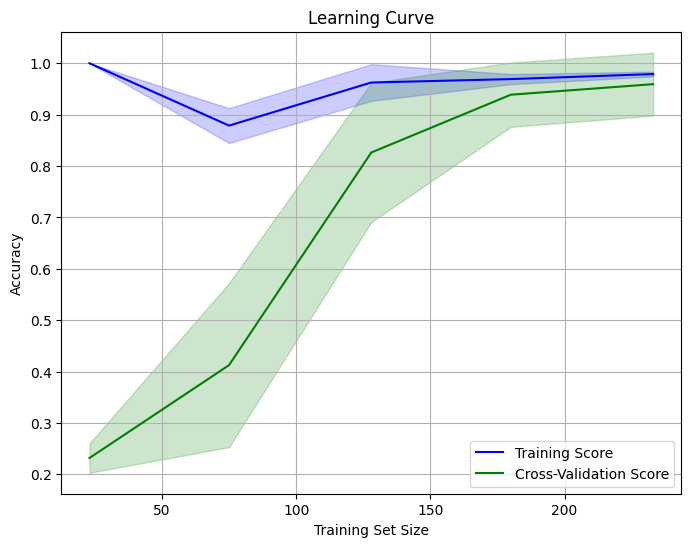

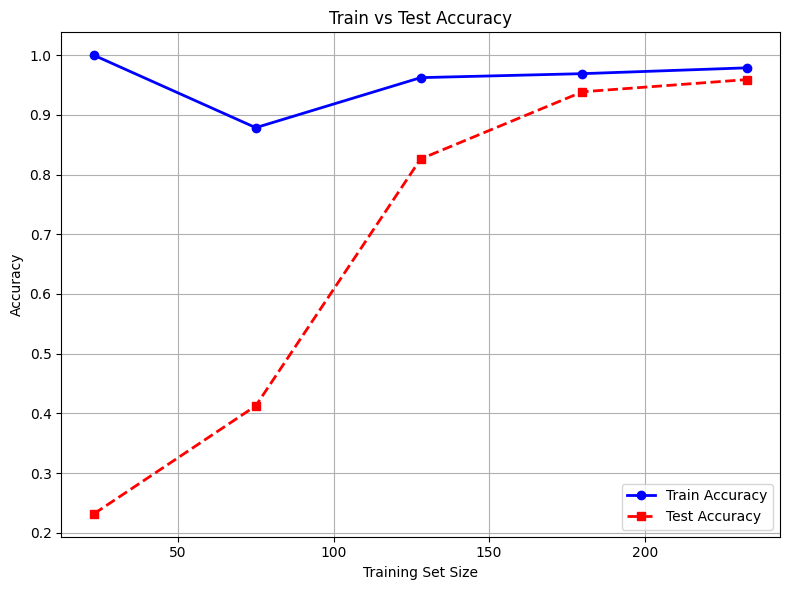

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, roc_curve, log_loss,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import learning_curve
import seaborn as sns

# AUC and ROC Curve
fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
auc_score = roc_auc_score(labels, preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Logarithmic Loss
log_loss_value = log_loss(labels, preds)
print(f"Logarithmic Loss: {log_loss_value:.2f}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Learning Curves
def plot_learning_curve(estimator, X, y, cv, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Train and Test Accuracy graph separately
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Train Accuracy', color='blue', marker='o', linestyle='-', linewidth=2)
    plt.plot(train_sizes, test_mean, label='Test Accuracy', color='red', marker='s', linestyle='--', linewidth=2)
    plt.title("Train vs Test Accuracy")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(clf, epochs_data, labels, cv)


# Polynomial Logistic Regression

In [125]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(XdawnCovariances(1),
                    TangentSpace(metric='riemann'),
                    PolynomialFeatures(degree=2, include_bias=False),
                    LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr'))

epochs_data = epochs.get_data()
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    preds[test_idx] = test_preds


report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

{'non-target': {'precision': 0.9540816326530612, 'recall': 0.9894179894179894, 'f1-score': 0.9714285714285714, 'support': 189.0}, 'target': {'precision': 0.96, 'recall': 0.8421052631578947, 'f1-score': 0.897196261682243, 'support': 57.0}, 'accuracy': 0.9552845528455285, 'macro avg': {'precision': 0.9570408163265306, 'recall': 0.915761626287942, 'f1-score': 0.9343124165554072, 'support': 246.0}, 'weighted avg': {'precision': 0.955452961672474, 'recall': 0.9552845528455285, 'f1-score': 0.954228402097105, 'support': 246.0}}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


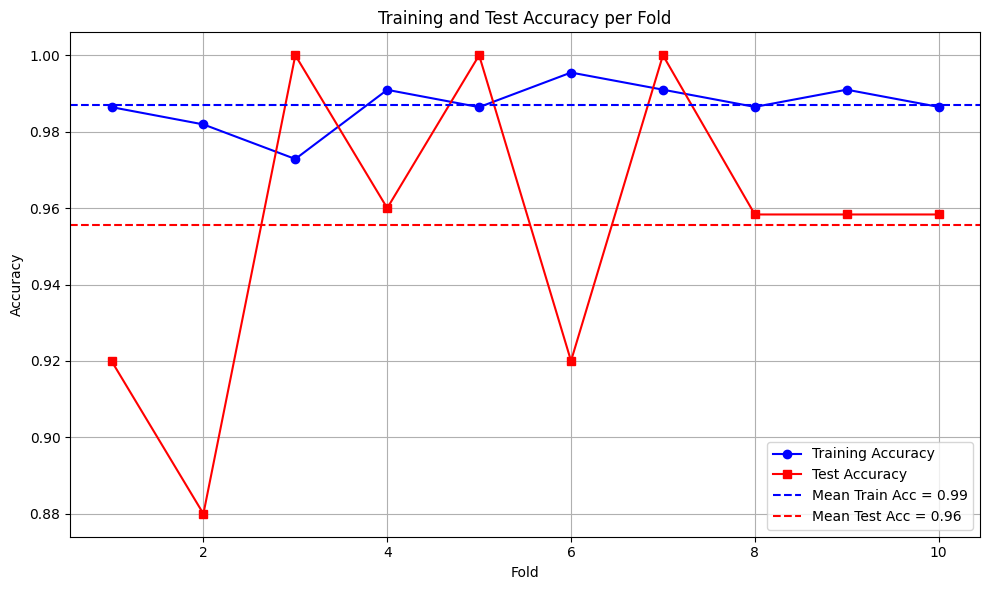

<Figure size 800x600 with 0 Axes>

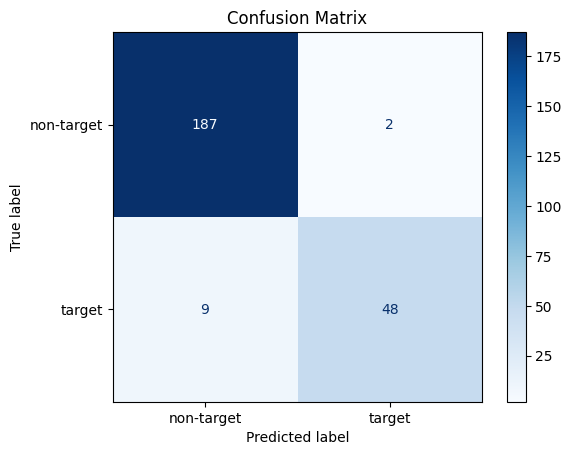

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot Training and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(np.mean(train_accuracies), linestyle='--', color='blue', label=f"Mean Train Acc = {np.mean(train_accuracies):.2f}")
plt.axhline(np.mean(test_accuracies), linestyle='--', color='red', label=f"Mean Test Acc = {np.mean(test_accuracies):.2f}")
plt.title("Training and Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
